In [1]:
# Add pyWRspice location to system path, if you haven't run setup.py
import sys
sys.path.append("pyWRspice/")

In [2]:
import numpy as np
import logging, importlib
from pyWRspice.pyWRspice import script, simulation, remote

import matplotlib.pyplot as plt
%matplotlib inline
logging.basicConfig(level=logging.WARNING)

engine = simulation.WRWrapper(command = "/mnt/c/Users/pstark/xictools/wrspice/bin/wrspice") # Typical for Unix

## Let's start with Andrew's example parallel circuit to demonstrate run-away behavior

In [10]:
parallel = """* Parallel
.model jj1 jj(level={level}, icrit={icrit_mag})
i1 0 1 ac sin({i1_phase} {i1_mag} {i1_freq})
b1 1 4 101 jj1 ics={ics_mag} phi={phi_mag}
l1 4 2 {l1_mag}
l2 2 0 {l2_mag}
ibias 1 2 {ibias_mag}
.tran {tran_step} {tran_stop} {tran_start} uic 
.control 
set maxdata={maxdata}
run 
set filetype=binary
write {output_file} i(l1) v(101)
.endc
"""

sw = simulation.WRWrapper(parallel, command = "/mnt/c/Users/pstark/xictools/wrspice/bin/wrspice")

In [11]:
params = {'level':1, 'icrit_mag': 1.0e-6, 'i1_phase': 0, 'i1_mag': 1e-9, 'i1_freq': 30e6, 'ibias_mag': 0,
          'l0_mag': 3e-12, 'k1_mag': 1, 'l1_mag': 3e-10, 'l2_mag': 0, 'lb_mag': 0, 'ics_mag': 1.1e-6, 'phi_mag': 0, 'lb_bias_mag': 3.0e-12,
          'tran_step': 1e-11, 'tran_stop': 6e-7, 'tran_start': 1e-7, 'maxdata': 1024000, 'output_file': None}

# Check the script before running
print(parallel.format(**params))

* Parallel
.model jj1 jj(level=1, icrit=1e-06)
i1 0 1 ac sin(0 1e-09 30000000.0)
b1 1 4 101 jj1 ics=1.1e-06 phi=0
l1 4 2 3e-10
l2 2 0 0
ibias 1 2 0
.tran 1e-11 6e-07 1e-07 uic 
.control 
set maxdata=1024000
run 
set filetype=binary
write None i(l1) v(101)
.endc



In [13]:
%%time
# Run the script by passing the params to the run() method
dat2 = engine.run(parallel, **params)

# Extract the data
dat2 = dat2.to_array()
ts = dat2[0]
v2 = dat2[1]
v3 = dat2[2]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 22.4 s


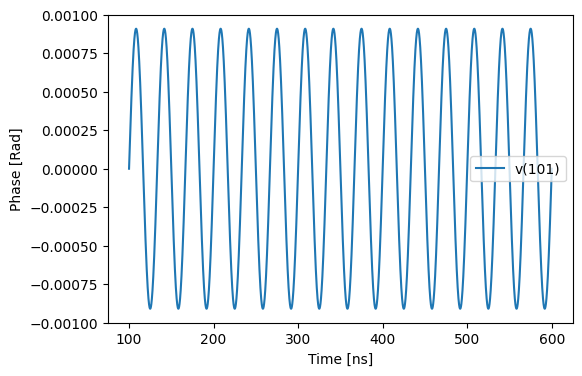

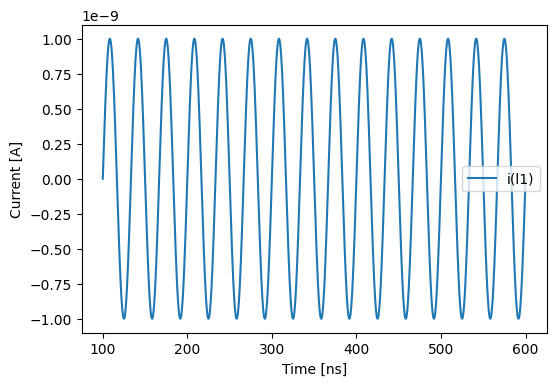

In [16]:
# Plot the data
plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v3, label="v(101)")
plt.xlabel("Time [ns]")
plt.ylabel("Phase [Rad]")
plt.legend()

plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v2, label="i(l1)")
plt.xlabel("Time [ns]")
plt.ylabel("Current [A]")
plt.legend()
plt.show()

In [21]:
### Now let's change the parameters a bit

params["tran_start"] = 0
params["tran_stop"] = 1e-7
params["tran_step"] = 1e-12
params["ibias_mag"] = 3e-9

In [22]:
%%time
dat2 = engine.run(parallel, **params)

# Extract the data
dat2 = dat2.to_array()
ts = dat2[0]
v2 = dat2[1]
v3 = dat2[2]

CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 3.84 s


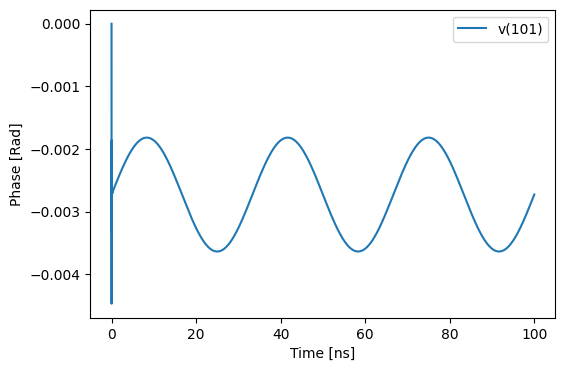

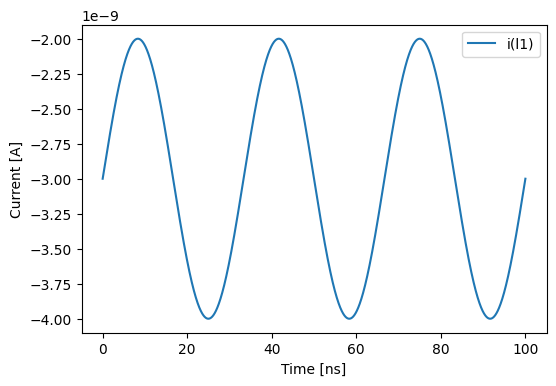

In [23]:
# Plot the data
plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v3, label="v(101)")
plt.xlabel("Time [ns]")
plt.ylabel("Phase [Rad]")
plt.legend()

plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v2, label="i(l1)")
plt.xlabel("Time [ns]")
plt.ylabel("Current [A]")
plt.legend()
plt.show()

In [25]:
### Now let's go over the critical current

params["ibias_mag"] = 2e-6

In [26]:
%%time
dat2 = engine.run(parallel, **params)

# Extract the data
dat2 = dat2.to_array()
ts = dat2[0]
v2 = dat2[1]
v3 = dat2[2]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 24.3 s


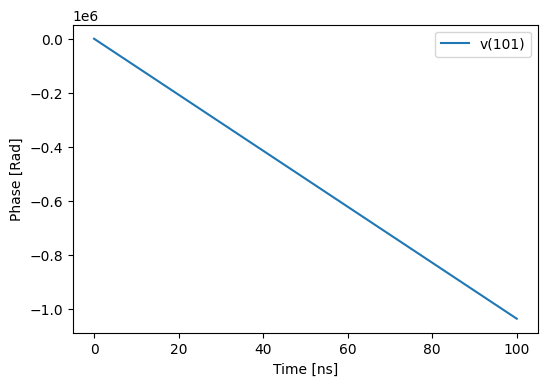

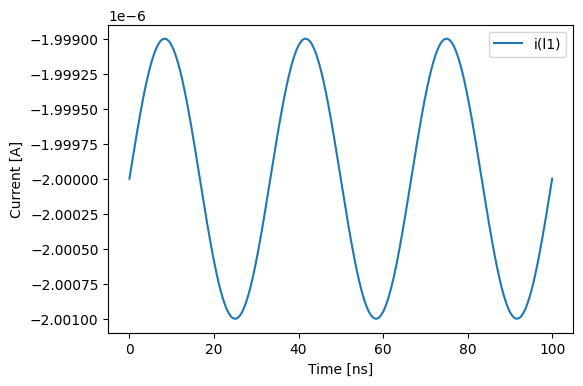

In [27]:
# Plot the data
plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v3, label="v(101)")
plt.xlabel("Time [ns]")
plt.ylabel("Phase [Rad]")
plt.legend()

plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v2, label="i(l1)")
plt.xlabel("Time [ns]")
plt.ylabel("Current [A]")
plt.legend()
plt.show()

### Now let's look at the series DC bias example

In [35]:
dc_bias = """* DC Bias circuit
.model jj1 jj(level={level}, icrit={icrit_mag})
i1 0 1 ac sin({i1_phase} {i1_mag} {i1_freq})
idc 0 1 {idc_mag}
*idc2 2 0 1e-2
l0 1 0 {l0_mag}
k1 l0 l1 {k1_mag}
l1 0 2 {l1_mag}
b1 2 0 101 jj1 ics={ics1_mag} phi={phi1_mag}
.tran {tran_step} {tran_stop} {tran_start} uic 
.control
set maxdata={maxdata}
run
set filetype=binary
write {output_file} i(l1) v(101)
.endc
"""

sw = simulation.WRWrapper(dc_bias, command = "/mnt/c/Users/pstark/xictools/wrspice/bin/wrspice")

In [36]:
params = {'level':1, 'icrit_mag': 1.0e-6, 'i1_phase': 0, 'i1_mag': 1e-9, 'i1_freq': 30e6, 'idc_mag': 0,
          'l0_mag': 3e-12, 'k1_mag': 1, 'l1_mag': 3e-12, 'ics1_mag': 1.1e-6, 'phi1_mag': 0,
          'l2_mag': 3e-10, 'tran_step': 1e-11, 'tran_stop': 6e-7, 'tran_start': 1e-7, 'maxdata': 1024000, 'output_file': None}

# Check the script before running
print(dc_bias.format(**params))

* DC Bias circuit
.model jj1 jj(level=1, icrit=1e-06)
i1 0 1 ac sin(0 1e-09 30000000.0)
idc 0 1 0
*idc2 2 0 1e-2
l0 1 0 3e-12
k1 l0 l1 1
l1 0 2 3e-12
b1 2 0 101 jj1 ics=1.1e-06 phi=0
.tran 1e-11 6e-07 1e-07 uic 
.control
set maxdata=1024000
run
set filetype=binary
write None i(l1) v(101)
.endc



In [37]:
%%time
# Run the script by passing the params to the run() method
dat2 = engine.run(dc_bias, **params)

# Extract the data
dat2 = dat2.to_array()
ts = dat2[0]
v2 = dat2[1]
v3 = dat2[2]

CPU times: user 15.6 ms, sys: 31.2 ms, total: 46.9 ms
Wall time: 21.5 s


Above critical current (input: 1e-4) we should see unstable phase? 
Below critical current (input: 1e-4) we see fixed flux bias

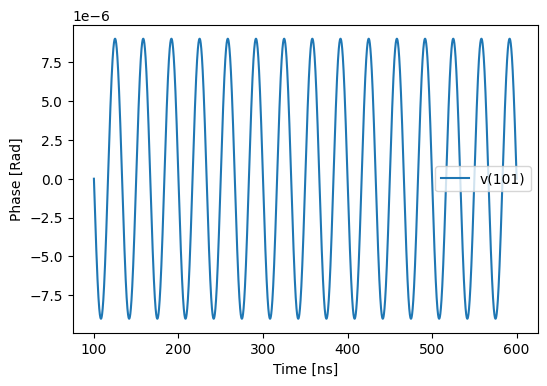

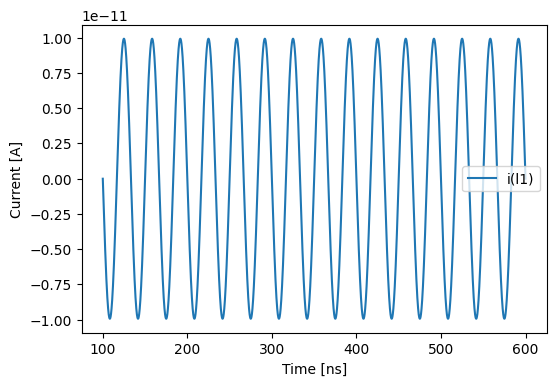

In [38]:
# Plot the data
plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v3, label="v(101)")
plt.xlabel("Time [ns]")
plt.ylabel("Phase [Rad]")
plt.legend()

plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v2, label="i(l1)")
plt.xlabel("Time [ns]")
plt.ylabel("Current [A]")
plt.legend()
plt.show()

In [39]:
### Now let's change the parameters a bit

params["tran_start"] = 0
params["tran_stop"] = 1e-7
params["tran_step"] = 1e-12
params["ibias_mag"] = 3e-9

In [40]:
%%time
# Run the script by passing the params to the run() method
dat2 = engine.run(dc_bias, **params)

# Extract the data
dat2 = dat2.to_array()
ts = dat2[0]
v2 = dat2[1]
v3 = dat2[2]

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 3.73 s


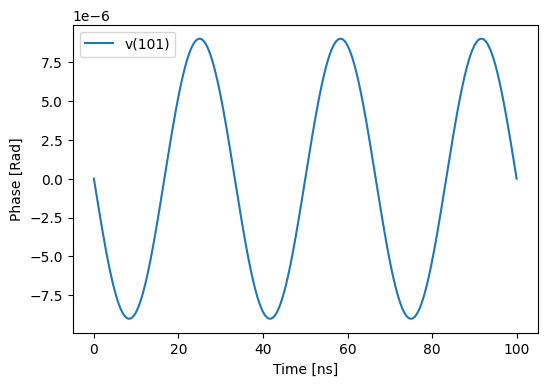

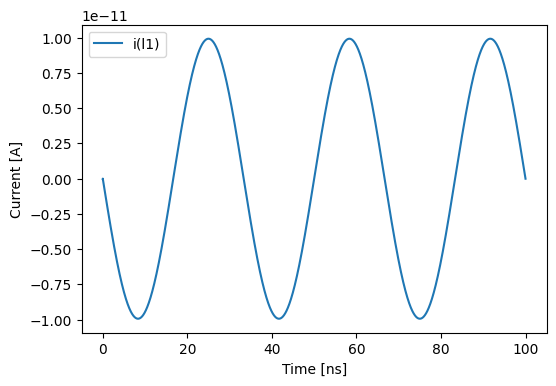

In [41]:
# Plot the data
plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v3, label="v(101)")
plt.xlabel("Time [ns]")
plt.ylabel("Phase [Rad]")
plt.legend()

plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v2, label="i(l1)")
plt.xlabel("Time [ns]")
plt.ylabel("Current [A]")
plt.legend()
plt.show()

In [45]:
### Now let's go over the critical current
params["ibias_mag"] = 2e-3

In [46]:
%%time
# Run the script by passing the params to the run() method
dat2 = engine.run(dc_bias, **params)

# Extract the data
dat2 = dat2.to_array()
ts = dat2[0]
v2 = dat2[1]
v3 = dat2[2]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.69 s


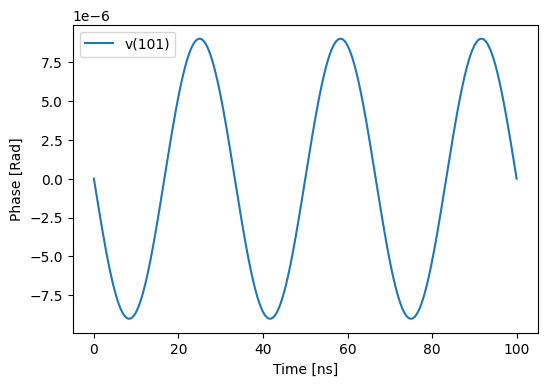

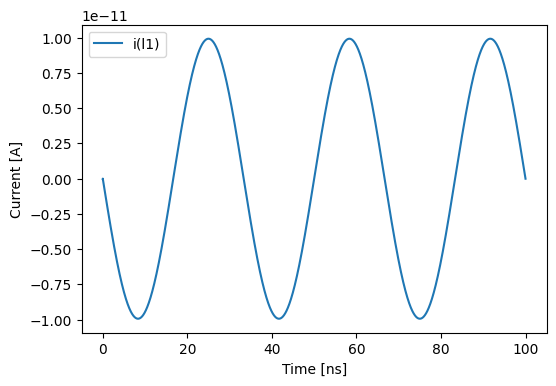

In [47]:
# Plot the data
plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v3, label="v(101)")
plt.xlabel("Time [ns]")
plt.ylabel("Phase [Rad]")
plt.legend()

plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v2, label="i(l1)")
plt.xlabel("Time [ns]")
plt.ylabel("Current [A]")
plt.legend()
plt.show()

### We see that the series circuit does not demonstrate the same loss of stability as compared to the parallel circuit. Even if our bias current is above the critical current of the JJ, we are always in the stable regime.

In [192]:
### I am interested in some observables of this circuit
def ij(ic, phase):
    return ic * np.sin(phase)

(0.0, 0.005)

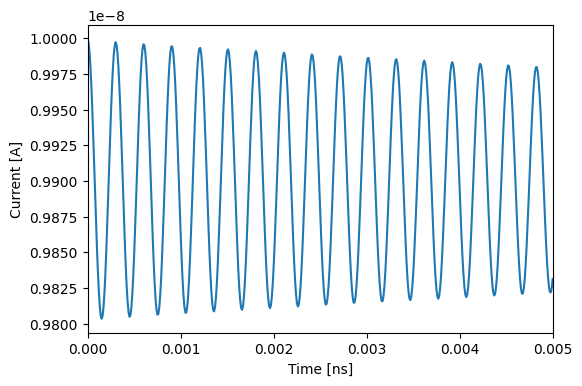

In [194]:
fig = plt.figure(figsize=(6,4))
plt.plot(ts*1e9, 1e-08 + ij(params["ics1_mag"], v3), label="I + I_bias")
#plt.plot(ts*1e9, v2, label="i(l1)")
plt.xlabel("Time [ns]")
plt.ylabel("Current [A]")

plt.xlim(0, 0.005)
#plt.xscale('log')

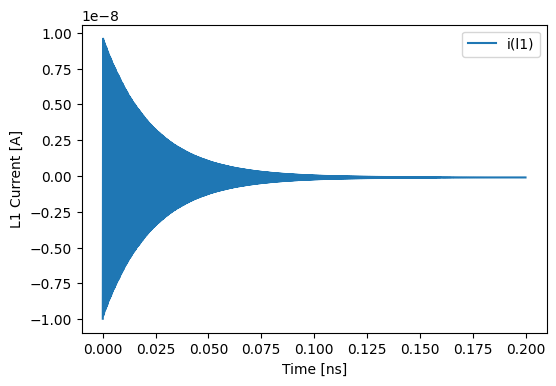

In [196]:
# Plot the data
fig = plt.figure(figsize=(6,4))
plt.plot(ts*1e9, v2, label="i(l1)")
plt.xlabel("Time [ns]")
plt.ylabel("L1 Current [A]")
plt.legend()
plt.show()

### Now let's look at a range of parameters to see if the flux biasing works with an input flux signal

In [52]:
%%time
# Recycle params above
params["idc_mag"] = np.logspace(1e-8, 1e-3, 100)

params3, dat3 = engine.run_parallel(dc_bias, save_file=False, **params)

CPU times: user 46.9 ms, sys: 188 ms, total: 234 ms
Wall time: 44.7 s


In [53]:
params["idc_mag"]

array([1.00000002, 1.00002328, 1.00004654, 1.0000698 , 1.00009306,
       1.00011632, 1.00013958, 1.00016284, 1.00018611, 1.00020937,
       1.00023263, 1.0002559 , 1.00027916, 1.00030243, 1.00032569,
       1.00034896, 1.00037222, 1.00039549, 1.00041876, 1.00044203,
       1.0004653 , 1.00048856, 1.00051183, 1.0005351 , 1.00055838,
       1.00058165, 1.00060492, 1.00062819, 1.00065146, 1.00067474,
       1.00069801, 1.00072129, 1.00074456, 1.00076784, 1.00079111,
       1.00081439, 1.00083767, 1.00086095, 1.00088423, 1.0009075 ,
       1.00093078, 1.00095406, 1.00097734, 1.00100063, 1.00102391,
       1.00104719, 1.00107047, 1.00109376, 1.00111704, 1.00114032,
       1.00116361, 1.0011869 , 1.00121018, 1.00123347, 1.00125676,
       1.00128004, 1.00130333, 1.00132662, 1.00134991, 1.0013732 ,
       1.00139649, 1.00141978, 1.00144307, 1.00146636, 1.00148966,
       1.00151295, 1.00153624, 1.00155954, 1.00158283, 1.00160613,
       1.00162942, 1.00165272, 1.00167602, 1.00169931, 1.00172

In [57]:
# Extract data
idcs = params3["idc_mag"]
v2s = []
v3s = []
for dat in dat3:
    v2s.append(dat.to_array()[1])
    v3s.append(dat.to_array()[2])
ts = dat.to_array()[0]

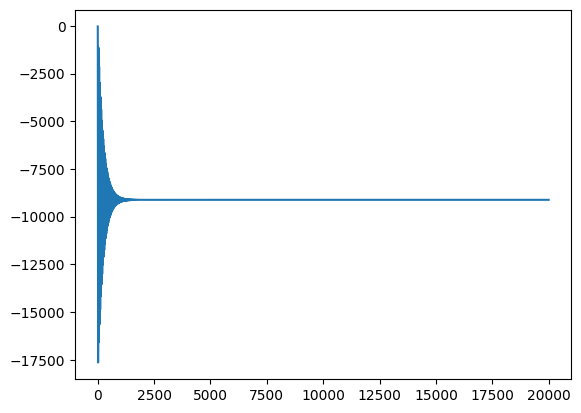

In [64]:
plt.plot(v3s[20])

Text(0, 0.5, 'JJ Flux (Rad)')

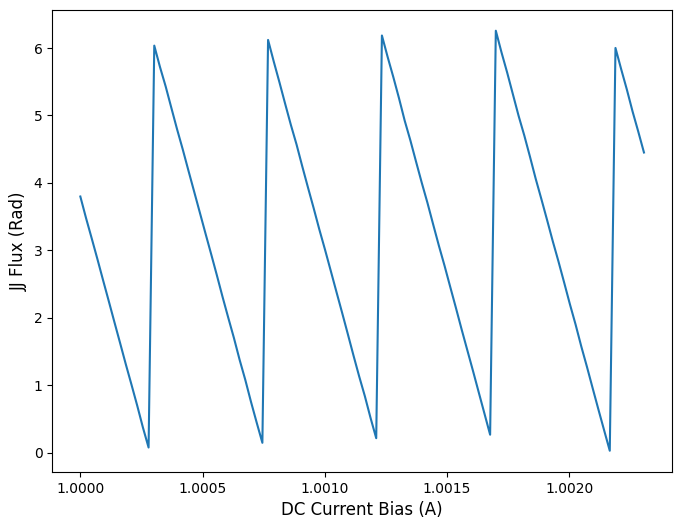

In [66]:
fig = plt.figure(figsize=(8,6))

rad = []

for idc, v3 in zip(idcs, v3s):
    rad.append(v3[50]%(2*np.pi))

plt.plot(idcs, rad)
plt.xlabel('DC Current Bias (A)', fontsize=12)
plt.ylabel('JJ Flux (Rad)', fontsize=12)
#plt.xscale('log')

#plt.savefig('dc_bias_vs_flux.jpg', bbox_inches='tight')

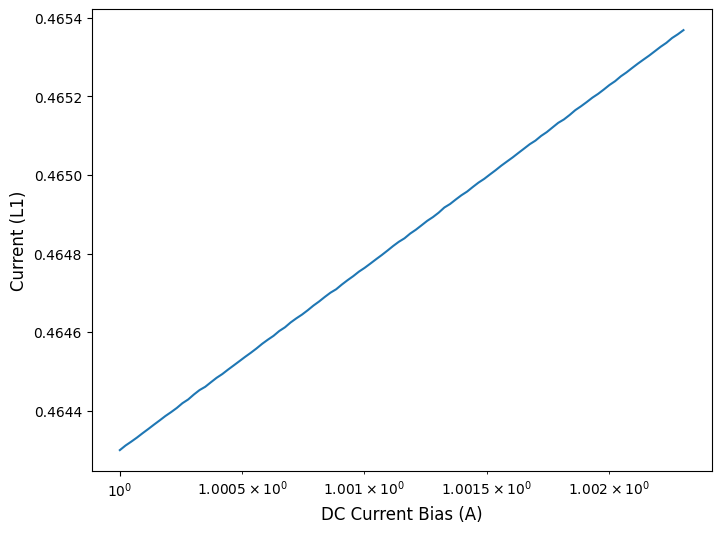

In [72]:
fig = plt.figure(figsize=(8,6))

rad = []

for idc, v2 in zip(idcs, v2s):
    rad.append(abs(v2[50]))

plt.plot(idcs, rad)
plt.xlabel('DC Current Bias (A)', fontsize=12)
plt.ylabel('Current (L1)', fontsize=12)
plt.xscale('log')

#plt.savefig('dc_bias_vs_flux.jpg', bbox_inches='tight')

In [20]:
# Plot the data
fig = plt.figure(figsize=(12,6))
for idc, v3 in zip(idcs, v3s):
    plt.plot(ts*1e9, v3%(2*np.pi), label="v(101) = %s Rad" %idc)
plt.xlabel("Time [ns]")
plt.ylabel("Rad")
plt.legend()
plt.show()

/home/pstark/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


KeyboardInterrupt: 

### Let's compare the results to that of a step function input

In [126]:
dc_bias_step = """* DC Bias circuit
.model jj1 jj(level={level}, icrit={icrit_mag})
*i1 0 1 ac sin({i1_phase} {i1_mag} {i1_freq})
idc 0 1 pulse(0 {idc_mag} 3e-07 0 0 1e-07)
l0 1 0 {l0_mag}
k1 l0 l1 {k1_mag}
l1 0 2 {l1_mag}
b1 2 0 101 jj1 ics={ics1_mag} phi={phi1_mag}
.tran {tran_step} {tran_stop} {tran_start} uic 
.control
set maxdata={maxdata}
run
set filetype=binary
write {output_file} i(l1) v(101)
.endc
"""

sw = simulation.WRWrapper(dc_bias, command = "/mnt/c/Users/pstark/xictools/wrspice/bin/wrspice")

In [127]:
params = {'level':1, 'icrit_mag': 1.0e-6, 'i1_phase': 0, 'i1_mag': 1e-9, 'i1_freq': 30e6, 'idc_mag': 1.06157895e-04,
          'l0_mag': 3e-12, 'k1_mag': 1, 'l1_mag': 3e-12, 'ics1_mag': 1.1e-6, 'phi1_mag': 0, 'ics2_mag': 2.2e-6, 'phi2_mag': 0,
          'l2_mag': 1e-10, 'tran_step': 1e-11, 'tran_stop': 6e-7, 'tran_start': 1e-7, 'maxdata': 1024000, 'output_file': None}
# Check the script before running
print(dc_bias_step.format(**params))

* DC Bias circuit
.model jj1 jj(level=1, icrit=1e-06)
*i1 0 1 ac sin(0 1e-09 30000000.0)
idc 0 1 pulse(0 0.000106157895 3e-07 0 0 1e-07)
l0 1 0 3e-12
k1 l0 l1 1
l1 0 2 3e-12
b1 2 0 101 jj1 ics=1.1e-06 phi=0
.tran 1e-11 6e-07 1e-07 uic 
.control
set maxdata=1024000
run
set filetype=binary
write None i(l1) v(101)
.endc



In [128]:
%%time
# Run the script by passing the params to the run() method
dat3 = engine.run(dc_bias_step, **params)

# Extract the data
dat3 = dat3.to_array()
ts3 = dat3[0]
v23 = dat3[1]
v33 = dat3[2]

CPU times: user 0 ns, sys: 31.2 ms, total: 31.2 ms
Wall time: 21.7 s


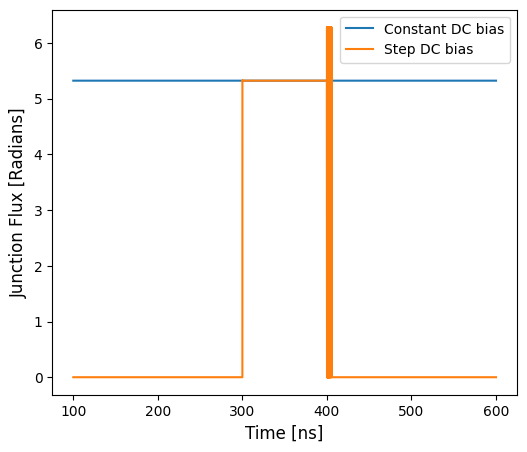

In [142]:
# Plot the data
fig = plt.figure(figsize=(6,5))
plt.plot(ts*1e9, v3%(2*np.pi), label="Constant DC bias")
plt.plot(ts3*1e9, v33%(2*np.pi), label="Step DC bias")
plt.xlabel("Time [ns]", fontsize=12)
plt.ylabel("Junction Flux [Radians]", fontsize=12)
plt.legend()
plt.savefig('dc_bias_test.jpg', bbox_inches='tight')
plt.show()

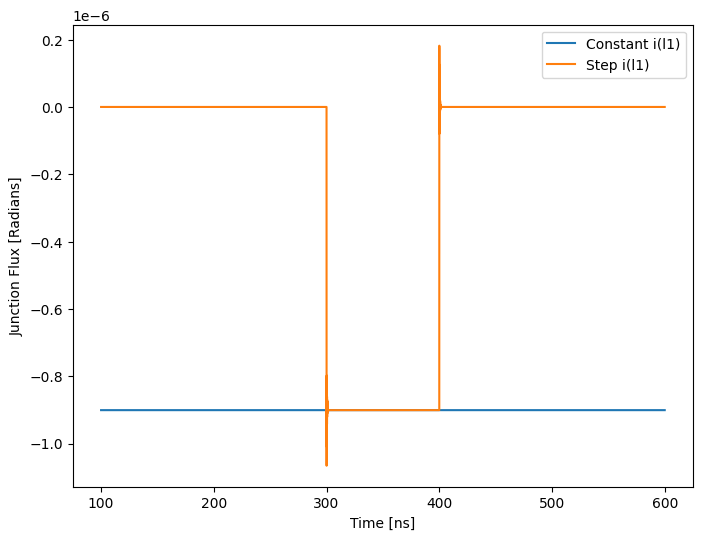

In [139]:
# Plot the data
fig = plt.figure(figsize=(8,6))
plt.plot(ts*1e9, v2, label="Constant i(l1)")
plt.plot(ts3*1e9, v23, label="Step i(l1)")
plt.xlabel("Time [ns]")
plt.ylabel("Junction Flux [Radians]")
plt.legend()
plt.show()